## **Gaussian Process Campaign with Functional Data**

In many scenarios, we may be dealing with *functional* data. This means that the input, output, or both, are sampled over a particular dimension (e.g. time). In `twinlab`, data are presented in column-feature format, meaning a single data sample of functional format may contain hundreds or thousands of columns. 

Gaussian Process models do not scale well to these scenarios, so we provide the ability to perform dimensionality reduction before model fitting. 

This notebook will cover:
- How to decompose functional inputs and outputs

In [11]:
# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# twinLab import
import twinlab as tl

### **Problem Formulation**
Here, we define a problem with two input dimensions and one functional output defined over a grid of sample locations

In [12]:
# Grid over which the functional output is defined
grid = np.linspace(0, 1)

# True function: Forrester function with variable a and b
def model(x):
    return (x[0] * grid - 2) ** 2 * np.sin(x[1] * grid - 4)

# Define input data
x = np.random.uniform(size=(100, 2))
x[:, 0] = x[:, 0] * 4 + 4
x[:, 1] = x[:, 1] * 4 + 10

# Compute output data
y = np.zeros((x.shape[0], grid.size))

for i, x_i in enumerate(x):
    y[i, :] = model(x_i)

y = {"y_{}".format(i): y[:, i] for i in range(grid.size)}

# Save to DataFrame
df = pd.DataFrame({"x1": x[:, 0], "x2": x[:, 1], **y})
df.head()

,x1,x2,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,...,y_40,y_41,y_42,y_43,y_44,y_45,y_46,y_47,y_48,y_49
0,5.302322,11.359526,3.02721,2.098569,1.223409,0.455290,-0.169086,-0.630502,-0.926359,-1.068498,...,-4.591453,-4.168226,-3.365424,-2.178178,-0.630555,1.222583,3.295894,5.476243,7.627767,9.599169
1,5.157736,11.402210,3.02721,2.102587,1.226367,0.452798,-0.180307,-0.652347,-0.959221,-1.111320,...,-4.044740,-3.625839,-2.860424,-1.746184,-0.307803,1.401454,3.300222,5.281753,7.218858,8.970926
2,6.143058,11.208983,3.02721,2.069411,1.194119,0.451708,-0.127058,-0.530803,-0.765674,-0.852158,...,-8.231475,-7.749750,-6.667539,-4.967292,-2.673716,0.142933,3.366550,6.838166,10.362295,13.716502
3,6.639279,11.806139,3.02721,2.012721,1.099200,0.343229,-0.223560,-0.593669,-0.780699,-0.814588,...,-7.035980,-4.975611,-2.219148,1.130654,4.911252,8.905909,12.854144,16.466678,19.444119,21.498281
4,4.156268,11.604090,3.02721,2.135925,1.257489,0.449153,-0.244765,-0.794590,-1.185688,-1.417657,...,-1.405797,-1.185013,-0.806876,-0.270932,0.409213,1.205015,2.073311,2.957933,3.792615,4.505073


In [13]:
# Define the name of the dataset
dataset_id = "FunctionalGP_Data"

# Upload the dataset to the cloud
tl.upload_dataset(df, dataset_id, verbose=True)

Dataframe is uploading.
Processing dataset.
Dataset FunctionalGP_Data was processed.


### **Functional Campaign Workflow**

In `twinlab`, dimensionality reduction is implemented in the form of truncated Singular Value Decomposition (tSVD), and is accessible via the convenience keyword parameters `decompose_inputs` and `decompose_outputs`, and the ratio of retained singular components are controlled by the keywords `input_explained_variance` and `output_explained_variance`.

One can decompose the inputs, outputs, or both in the same `Campaign`.

In [14]:
# Initialise campaign
campaign_id = "FunctionalGP"

campaign_params = {
    "dataset_id": dataset_id,                   # This points the campaign to the uploaded dataset
    "inputs": list(df.columns[:2]),             # Using the datasets column headers define the input and output data
    "outputs": list(df.columns[2:]),
    "test_train_ratio": 0.75,                   # Determine how much data is used for training, here 75% is used to train the model  
    "estimator": "gaussian_process_regression", # and 25% is used to test it.
    "decompose_inputs": False,                  # Whether to reduce input dimensions
    "input_explained_variance": 0.99,           # Keep 99% of variance information in the data
    "decompose_outputs": True,                  # Whether to reduce output dimensions
    "output_explained_variance": 0.99999,
}                                        

# Start a new campaign and train a surrogate model
tl.train_campaign(campaign_params, campaign_id, verbose=True)

Model FunctionalGP has begun training.


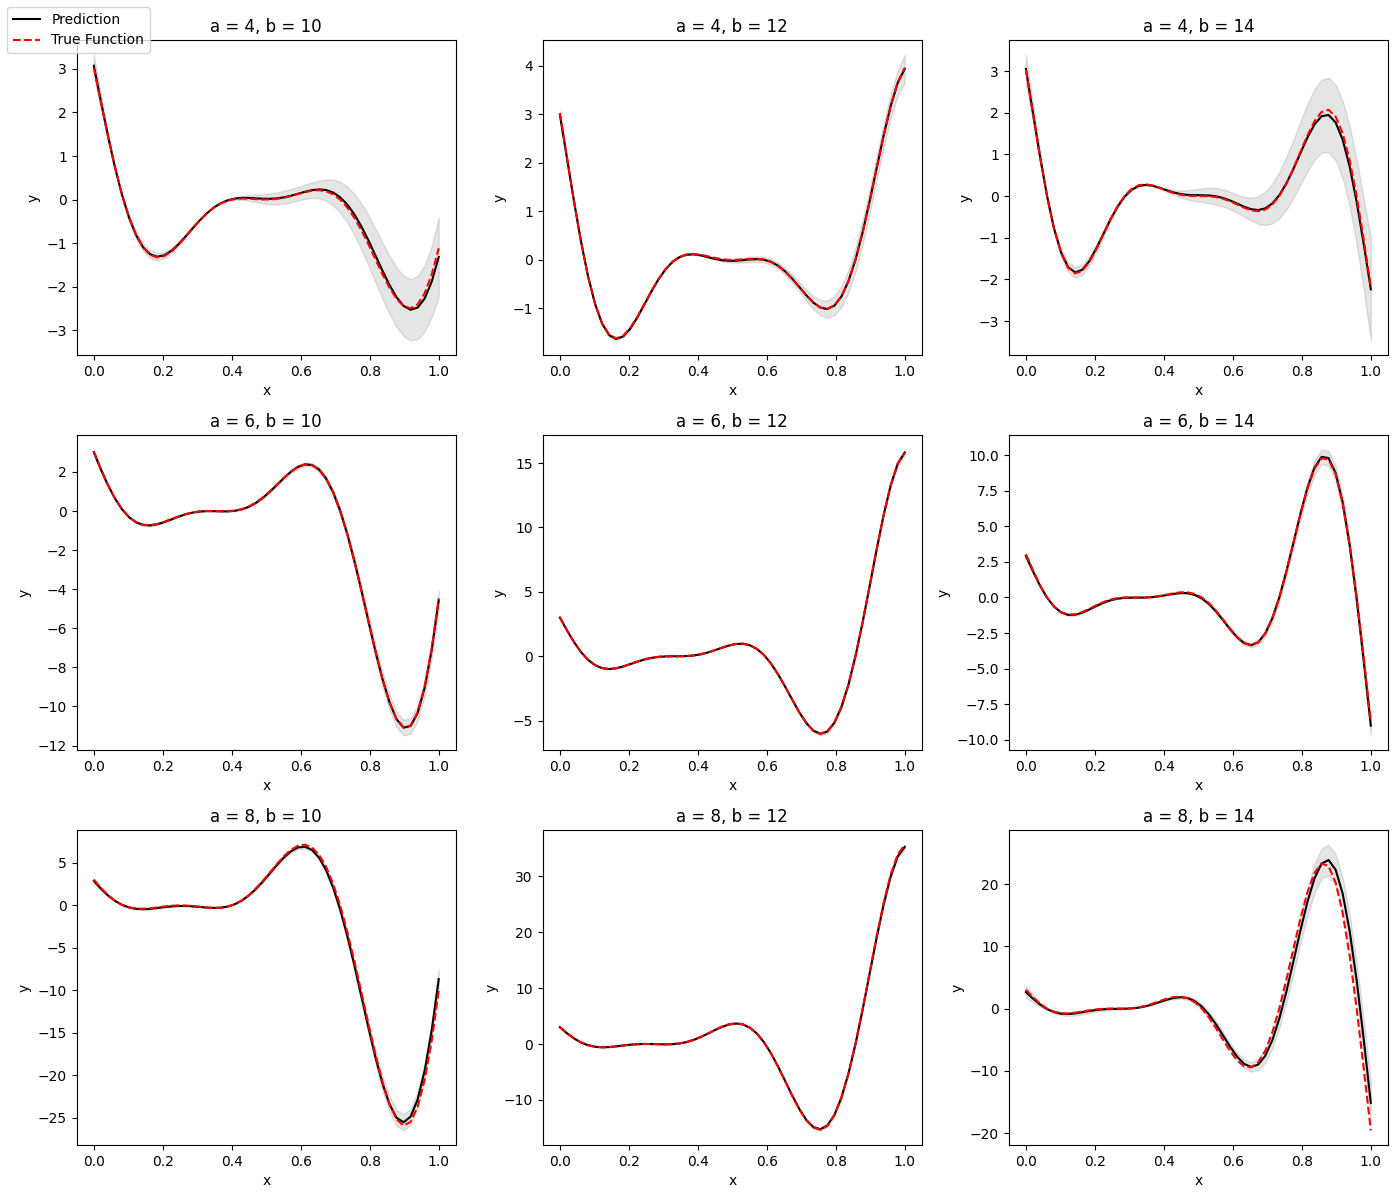

In [15]:
# Create grid of output plots
grid = np.linspace(0, 1)

x1 = [4, 6, 8]
x2 = [10, 12, 14]

X = np.array(list(product(x1, x2)))
ax_i = list(product([0, 1, 2], [0, 1, 2]))

# Create output plot and save in directory
fig, axes = plt.subplots(figsize=(14, 12), nrows=3, ncols=3)

# Setup legend
legend_labels = {}

for i, x_i in enumerate(X):
    r, c = ax_i[i]
    ax = axes[r, c]

    X_test = pd.DataFrame(x_i[np.newaxis, :], columns=["x1", "x2"])
    y_test = model(X_test.values.flatten())

    y_mean, y_stdev = tl.predict_campaign(X_test, campaign_id)
    y_mean = y_mean.values
    y_stdev = y_stdev.values

    ax.set_title("a = {}, b = {}".format(x_i[0], x_i[1]))
    ax.plot(grid, y_mean.flatten(), c="k")
    ax.plot(grid, y_test.flatten(), c="red", linestyle="dashed")
    ax.fill_between(
        grid,
        (y_mean - 1.96 * y_stdev).flatten(),
        (y_mean + 1.96 * y_stdev).flatten(),
        color="k",
        alpha=0.1,
    )

    ax.set_xlabel("x")
    ax.set_ylabel("y")

# Store labels for the legend
legend_labels[f"Prediction"] = plt.Line2D([0], [0], color="k")
legend_labels[f"True Function"] = plt.Line2D([0], [0], color="red", linestyle="dashed")

# Print legend
fig.legend(legend_labels.values(), legend_labels.keys(), loc="upper left")
fig.tight_layout()

In [16]:
# Delete campaign and dataset
tl.delete_campaign(campaign_id)

tl.delete_dataset(dataset_id)